# Задача 11-9-3

Построить алгоритм метода пристрелки для вычисления решения следующей нелинейной задачи:
    
$$
    y'' - 10 x \sqrt{y} = 0, \quad 0 < x < 1
$$

$$
    y(0) = 0, \quad y(1) = 2
$$

Код программы был написан так, чтобы его можно было достаточно легко перепрофилиролировать под другую 
краевую задачу. Этим вызвана большая модульность программы. 

Введем пристрелочный параметр $\alpha$: $y'(0) = \alpha$. $y_\alpha(x)$ - решение, соответствующее данному пристрелочному параметру. На правом конце будем искать ноль функции:

$$
    r(\alpha) = y_\alpha(2) - 2
$$

По методу Ньютона:
  
$$
        \alpha_{n+1} = \alpha_n - \frac{r(\alpha_n)}{p_{\alpha_n(1)}}
$$

$$
    p_{\alpha_n}(x) = \frac{\partial y_{\alpha_n}}{ \partial \alpha_n}(x)
$$

Уравнение на $p_{\alpha_n}(x)$:

$$
    p''_{\alpha_n}(x) - x \frac{p}{2 \sqrt{y(x)}} = 0
$$

Будем решать оба дифференциальных уравнения с помощьюю ЯМРК-4, так как задачи нежесткие.

In [12]:
import matplotlib.pyplot as plt
import numpy as np

In [13]:
# Перепишем через систему первого порядка u = [y', y]
def f(x, u):
    return np.array([10 * x * np.sqrt(abs(u[1])), u[0]])
    #return np.array([-0.5 * u[0] * u[0] / (1 - 0.5 * u[1]), u[0]])

In [14]:
# Функция в правой части уравнения в вариациях: q = [p', p] 
def g(x, q, u):
    if u[1] != 0:
        return np.array([10 * x * q[1]/2/np.sqrt(abs(u[1])), q[0]])
        #return np.array([])
    else:
        #print("Ошибка извлечения корня из отрицательного числа при вычислении функции g!")
        print("Ошибка деления на 0 при вычислении функции g!")
        return np.array([])

In [15]:
# краевое условие на правом конце u - решение[[y'], [y]]
def r(u, N):
    return u[1][N] - 2

In [16]:
# Производная по параметру краевого условия на правом конце
def dr(u, p, N):
    return p[1][N]

In [17]:
def rk(f, u0, h, a, b):
    N = int((b - a) / h)
    
    u = np.empty((N + 1, 2))
    x = np.arange(a, b + h, h)
    
    # Используем начальное условие
    u[0] = u0
    
    for n in range(0, N):
        k1 = f(x[n], u[n])
        k2 = f(x[n] + h / 2, u[n] + h * k1 / 2)
        k3 = f(x[n] + h / 2, u[n] + h * k2 / 2)
        k4 = f(x[n] + h, u[n] + h * k3)
        
        u[n + 1] = u[n] + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    return np.array([x, u.transpose()])

In [18]:
# Решаем уравнение, продифференцированное по прицельному параметру на данном решении u.
# Определяем q = [p', p]
# alpha - пристрелочный параметр
def rk_p(g, alpha, u, h, a, b):
    N = int((b - a) / h)
    
    q = np.empty((N + 1, 2))
    x = np.arange(a, b + h, h)
    u = u.transpose()
    
    # Задаем начальное условие, дифференцируя краевые условия по прицельному параметру alpha
    q[0] = [alpha, 0]
    
    for n in range(0, N):
        
        k1 = g(x[n], q[n], u[n])
        if (len(k1) == 0):
            continue
        
        k2 = g(x[n] + h / 2, q[n] + h * k1 / 2, u[n])
        if (len(k2) == 0):
            continue
        
        k3 = g(x[n] + h / 2, q[n] + h * k2 / 2, u[n])
        if (len(k3) == 0):
            continue
        
        k4 = g(x[n] + h, q[n] + h * k3, u[n])
        if (len(k4) == 0):
            continue
            
        q[n + 1] = q[n] + h * (k1 + 2 * k2 + 2 * k3 + k4) / 6
    
    return np.array([x, q.transpose()])

In [19]:
def make_graph(x, y, h, title):
    
    fig = plt.figure(figsize = (12, 9))
    ax = fig.add_subplot(111)
    #plt.plot(arg, val)
    
    l = 2.
    f = 20
    
    # строим решение для данного шага
    ax.plot(x, y, color="red", linewidth = l, label="h = " + str(h))
    
    ax.grid(True)
    ax.legend(fontsize = f)
    plt.title(title, fontsize = f)
 
    plt.show() 

In [20]:
def num_sol(f, u0, h, title, a = 0, b = 1):
    sol = rk(f, u0, h, a, b)
    make_graph(sol[0], sol[1][1], h, title)
    return sol

In [21]:
def num_sol_p(g, alpha, u, h, title, a = 0, b = 1):
    q = rk_p(g, alpha, u, h, a, b)
    make_graph(q[0], q[1][1], h, title)
    return q

После написания основных функций, проверим их работу.

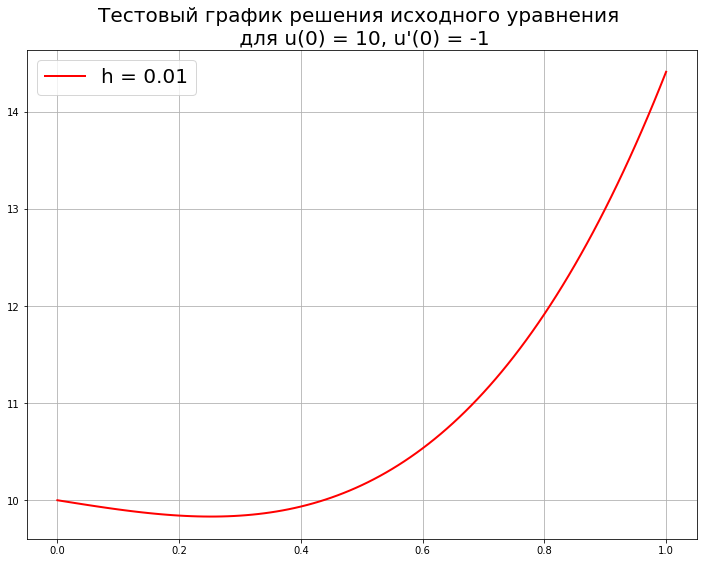

In [22]:
u = num_sol(f, [-1, 10], 0.01, "Тестовый график решения исходного уравнения \n для u(0) = 10, u'(0) = -1")

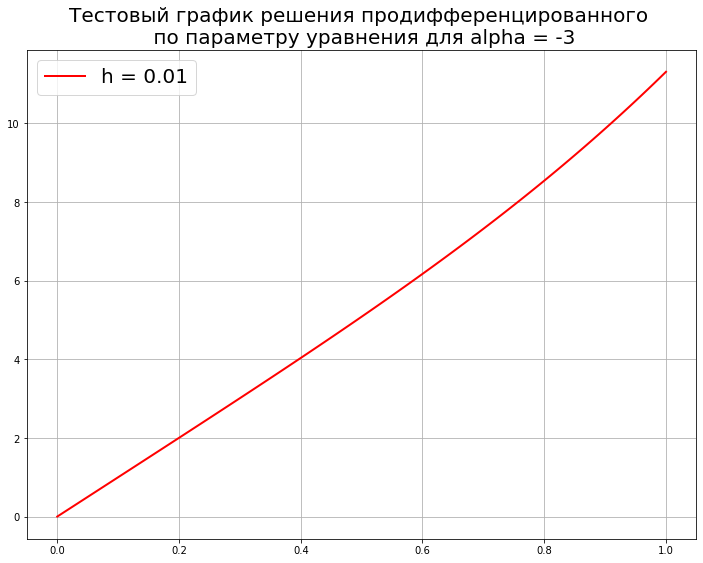

In [23]:
q = num_sol_p(g, 10, u[1], 0.01, "Тестовый график решения продифференцированного \n по параметру уравнения для alpha = -3")

Напишем функцию решения уравнения краевого условия методом Ньютона. Максимальное количество итераций - 100. 
Точность далее зададим равной 0.01.

In [24]:
def find_sol(h, eps, N, alpha0):
    err = 1;
    
    a = 0
    b = 1
    i = 0
    
    alpha = alpha0
    
    while (err > eps) and (i <= 100):
        i+=1
        
        u = rk(f, [alpha, 0], h, a, b)
        err = abs(r(u[1], N))
        p = rk_p(g, alpha, u[1], h, a, b)
        
        # Обрабатываем ошибку деления на 0
        if dr(u[1], p[1], N) == 0:
           print("Ошибка деления на 0 в ходе итераций метода Ньютона!")
           break
            
        alpha = alpha  - r(u[1], N) / dr(u[1], p[1], N)
        
        
    return [p[0], u[1], alpha]

In [25]:
final = find_sol(0.01, 0.01, 100, 0.5)

Ошибка деления на 0 при вычислении функции g!
Ошибка деления на 0 при вычислении функции g!
Ошибка деления на 0 при вычислении функции g!
Ошибка деления на 0 при вычислении функции g!
Ошибка деления на 0 при вычислении функции g!
Ошибка деления на 0 при вычислении функции g!
Ошибка деления на 0 при вычислении функции g!
Ошибка деления на 0 при вычислении функции g!


Ошибки деления на 0 были специально отловлены в ходе программе. Они связаны с попаданиями в точки $y = 0$. 
Но так как остальных точек куда больше, то на график эти выбросы практически не влияют. 

Пишем окончательное решение.

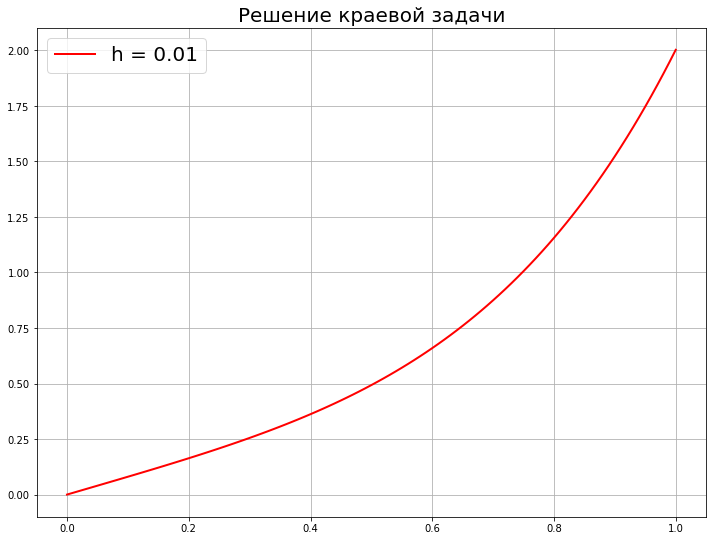

In [26]:
make_graph(final[0], final[1][1], 0.01, "Решение краевой задачи")

Приятный и удобный алгоритм для нежестких задач. График соответствует заданным краевым условиям.